In [1]:
import porespy as ps
import numpy as np 
import matplotlib.pyplot as plt
import scipy.ndimage as spim
import scipy.io as sio
import openpnm as op
import imageio
import numpy as np
from porespy.filters import find_peaks, trim_saddle_points, trim_nearby_peaks
from porespy.tools import randomize_colors
from skimage.morphology import watershed
from matplotlib import cm

ps.visualization.set_mpl_style()

### Load pore structure and LB simulation data

In [2]:
velocityData = np.loadtxt('velocity.dat')
velocityData = np.reshape(velocityData,(126,126,126,3))

velocityNormData = np.loadtxt('velocityNorm.dat')
np.shape(velocityNormData)
velocityNormData = np.reshape(velocityNormData,(126,126,126))

data = np.loadtxt("monoPack_126.dat",delimiter=',')
beadPack = np.reshape(data,(126,126,126))

# Porespy pore labelling
#Solid phase is False (0)
#Liquid phase/pore phase is True (1)

In [3]:
#beadPack = np.transpose(beadPack,(1,2,0))


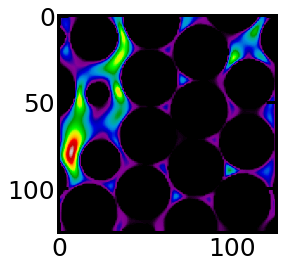

In [4]:
#plt.figure(1)
#plt.imshow(velocityData[:,:,100], cmap=plt.cm.nipy_spectral)

plt.figure(2)
plt.imshow(velocityNormData[:,:,80], cmap=plt.cm.nipy_spectral)

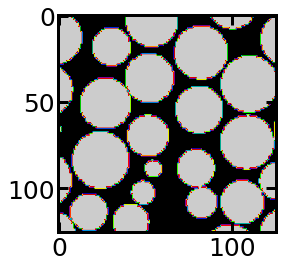

In [5]:
#Adjust to match Porespy
origPack = beadPack
beadPack[np.where(origPack >= 1)] = 1
beadPack[np.where(origPack < 1)] = 0


plt.imshow(beadPack[:,:,90],cmap=plt.cm.nipy_spectral)


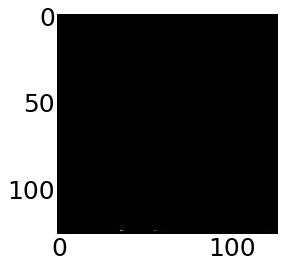

In [6]:
origPack = beadPack
#prevPack = beadPack
#beadPack[np.where(beadPack >1)] = 0
#beadPack[np.where(prevPack <1)] = 1

#This should be black since porespace is zero
plt.imshow((beadPack*velocityNormData)[:,:,80],cmap=plt.cm.nipy_spectral)


### Compute pore network information

In [7]:
#beadPack = origPack
sigma = 0.4
dt = spim.distance_transform_edt(input=beadPack)
dt = spim.gaussian_filter(input=dt, sigma=sigma)
peaks = find_peaks(dt=dt)


print('Initial number of peaks: ', spim.label(peaks)[1])
peaks = trim_saddle_points(peaks=peaks, dt=dt, max_iters=500)
print('Peaks after trimming saddle points: ', spim.label(peaks)[1])
peaks = trim_nearby_peaks(peaks=peaks, dt=dt)
peaks, N = spim.label(peaks)
print('Peaks after trimming nearby peaks: ', N)

Initial number of peaks:  124
Peaks after trimming saddle points:  123
Peaks after trimming nearby peaks:  123


In [10]:
snow_output = ps.networks.snow(beadPack,
                               voxel_size=1,
                               boundary_faces=['left','right','front','back','top','bottom'],
                               marching_cubes_area=False)

____________________________________________________________
Beginning SNOW Algorithm
Converting supplied image (im) to boolean
Peforming Distance Transform
Applying Gaussian blur with sigma = 0.4
Initial number of peaks:  124
Peaks after trimming saddle points:  123
Peaks after trimming nearby peaks:  123


 11%|█         | 28/253 [00:00<00:00, 267.66it/s]

____________________________________________________________
Extracting pore and throat information from image


100%|██████████| 253/253 [00:00<00:00, 379.41it/s]


In [8]:
# Ignoring the output of this cell should not be necessary...
# I'm guessing there are deprecation warnings being issued?
regions = watershed(image=-dt, markers=peaks, mask=dt > 0)
regions = randomize_colors(regions)

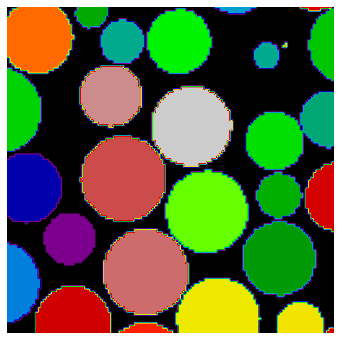

In [9]:
plt.figure(figsize=(6, 6))
plt.imshow((regions*beadPack)[:, :, 14], cmap=plt.cm.nipy_spectral)
plt.axis('off')
plt.show()


In [ ]:
#NBVAL_IGNORE_OUTPUT
im=regions*beadPack
new_im = im.astype(int)

net = ps.networks.regions_to_network(im=new_im, dt=dt, voxel_size=1)

In [ ]:
pn = op.network.GenericNetwork()
pn.update(net)
prj = pn.project
prj.export_data(filename='extracted_network', filetype='vtk')


In [ ]:
#NBVAL_IGNORE_OUTPUT
im = ps.tools.align_image_with_openpnm(im).astype(int)
ps.io.to_vtk(im, path='.extracted_network')


In [ ]:
net.keys()

In [ ]:
net.get("pore.label")

from collections import OrderedDict
test = OrderedDict(sorted(net.items(),key=lambda t: t[0]))

net.get("pore.label")

In [ ]:
len(beadPack)
velocities = {}
velocities.setdefault(str(net.get("pore.label")[1]),[])


print(velocities)
velocities['2'].append(1)
print(velocities)

#velocities['2'].append(36)
#print(velocities)

#sum(velocities['2'])/len(velocities['2'])


In [ ]:
cubeSize = len(beadPack)

velocities = {}

regionMap = regions*beadPack

for a in range(0, cubeSize): 
    for b in range(0, cubeSize):
        for c in range(0, cubeSize):
            
            #print(beadPack[a,b,c])
                        
            key = str(regionMap[a,b,c])
            if key != '0.0':
                if key in velocities:
                    velocities[key].append(velocityNormData[a,b,c])
                else:
                    velocities.setdefault(key,[])
                    velocities[key].append(velocityNormData[a,b,c])
        
            

print(velocities)            
            
            
            